In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/MyDrive/

/content/drive/MyDrive


In [ ]:
ls

3DCNN_NIFTI.ipynb       RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16July2021/
BraTS21-17_Mapping.csv  RSNA_ASNR_MICCAI_BraTS2021_ValidationData/


In [ ]:
import nibabel as nib
from scipy import ndimage
import matplotlib.pyplot as plt

In [ ]:
def read_nifti_file(path):
    return nib.load('RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16July2021/' + path + '.nii.gz').get_fdata()[50:190]

In [ ]:
def resize_volume(img):
    desired_depth = 135
    desired_width = 240
    desired_height = 150
    
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

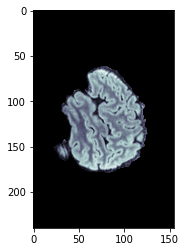

(140, 240, 155)

In [ ]:
sample = read_nifti_file('BraTS2021_00000/BraTS2021_00000_flair')
plt.imshow(sample[len(sample[0])//2], cmap = 'bone')
plt.show()
sample.shape

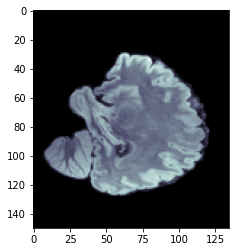

(240, 150, 135)

In [ ]:
sample_re = resize_volume(sample)
plt.imshow(sample_re[len(sample_re[0])//2], cmap = 'bone')
plt.show()
sample_re.shape

In [ ]:
import pandas as pd
data = pd.read_csv('BraTS21-17_Mapping.csv')
data.head()

,BraTS2021,BraTS2020,BraTS2019,BraTS2018,BraTS2017,Cohort Name (if publicly available),Site No (represents the originating institution),Local ID
0,BraTS2021_01163,NaN,NaN,NaN,NaN,ACRIN-FMISO-Brain (ACRIN 6684),19,ACRIN-FMISO-Brain-004
1,BraTS2021_01164,NaN,NaN,NaN,NaN,ACRIN-FMISO-Brain (ACRIN 6684),19,ACRIN-FMISO-Brain-034
2,BraTS2021_01165,NaN,NaN,NaN,NaN,ACRIN-FMISO-Brain (ACRIN 6684),19,ACRIN-FMISO-Brain-036
3,BraTS2021_01166,NaN,NaN,NaN,NaN,ACRIN-FMISO-Brain (ACRIN 6684),19,ACRIN-FMISO-Brain-042
4,BraTS2021_00101,NaN,NaN,NaN,NaN,CPTAC-GBM,20,C3L-00016


In [ ]:
#data = data.sort_values(by='BraTS2021')
data.drop(data[pd.isnull(data.BraTS2021)].index, inplace=True)
data.drop(range(100,1251), inplace = True)
data.drop(['BraTS2020', 'BraTS2019', 'BraTS2018', 'BraTS2017', 'Cohort Name (if publicly available)', 'Site No (represents the originating institution)', 'Local ID ' ], inplace=True, axis=1)
data

,BraTS2021
0,BraTS2021_01163
1,BraTS2021_01164
2,BraTS2021_01165
3,BraTS2021_01166
4,BraTS2021_00101
...,...
95,BraTS2021_00591
96,BraTS2021_00593
97,BraTS2021_00594
98,BraTS2021_00596


In [ ]:
Scan_path_xdata = [i + '/' + i + '_flair' for i in data.BraTS2021]
Scan_path_ydata = [i + '/' + i + '_seg' for i in data.BraTS2021]

In [ ]:
def process_nifti(path):
    image = read_nifti_file(path)
    image = resize_volume(image)
    return image

In [ ]:
import numpy as np
x_scans = np.array([process_nifti(path) for path in Scan_path_xdata])
y_scans = np.array([process_nifti(path) for path in Scan_path_ydata])

In [ ]:
x_train = x_scans[:80]
y_train = y_scans[:80]
x_test = x_scans[80:]
y_test = y_scans[80:]

In [ ]:
import tensorflow as tf
def preprocessing(x_data, y_data):
    x_data = tf.expand_dims(x_data, axis=3)
    y_data = tf.expand_dims(y_data, axis=3)
    return x_data, y_data

In [ ]:
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [ ]:
batch_size = 4
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_test))
    .map(preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

In [ ]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)

#[0]
x_val, y_val = list(data)[0]
#x_val = list(x_val)
images = x_val.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.rot90(image[64,:,:,0]), cmap="gray")

In [ ]:
import keras
import tensorflow.keras.layers as layers
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 63, 63, 31, 64)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 31, 64)   256       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 61, 61, 29, 64)    110656    
                                                             

In [ ]:
import tensorflow.keras as keras
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100


ValueError: ignored